### Import Libraries and Download Image

In [1]:
import numpy as np
import cv2
from scipy.special import j1
from scipy.fft import fft2, ifft2, fftfreq
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
from scipy.fft import fft2, fftshift
from PIL import Image

In [2]:
from utils import *

In [50]:
!wget https://raw.githubusercontent.com/antimatter15/cameraman/refs/heads/master/cameraman.tif

--2025-04-02 00:12:54--  https://raw.githubusercontent.com/antimatter15/cameraman/refs/heads/master/cameraman.tif
Risoluzione di raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connessione a raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connesso.
Richiesta HTTP inviata, in attesa di risposta... 200 OK
Lunghezza: 65240 (64K) [image/tiff]
Salvataggio in: «cameraman.tif.1»

cameraman.tif.1     100%[===================>]  63,71K  --.-KB/s    in 0,03s   

2025-04-02 00:12:54 (2,29 MB/s) - «cameraman.tif.1» salvato [65240/65240]



### Handle Vanilla Image

In [3]:
vanilla_image = Image.open('cameraman.tif')
vanilla_image.save('cameraman.png')

In [4]:
# Open the image and convert to grayscale (if not already)
vanilla_image = Image.open('cameraman.png').convert('L')  # 'L' converts to 8-bit grayscale

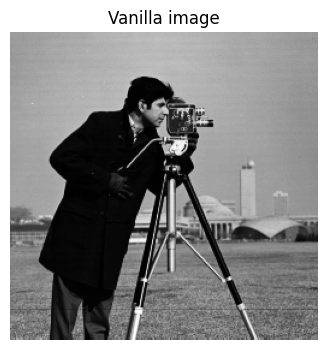

In [5]:
plt.figure(figsize=(4, 4))
plt.title("Vanilla image")
plt.imshow(vanilla_image,  cmap='gray')
plt.axis('off')

plt.show()

In [6]:
# Convert the image into Numpy array
vanilla_image = np.array(vanilla_image)

# Normalize the image
vanilla_image = vanilla_image / 255.0

print(f"Image shape is: {vanilla_image.shape}")

Image shape is: (256, 256)


### Visualize Blurred Image with Different Kernels

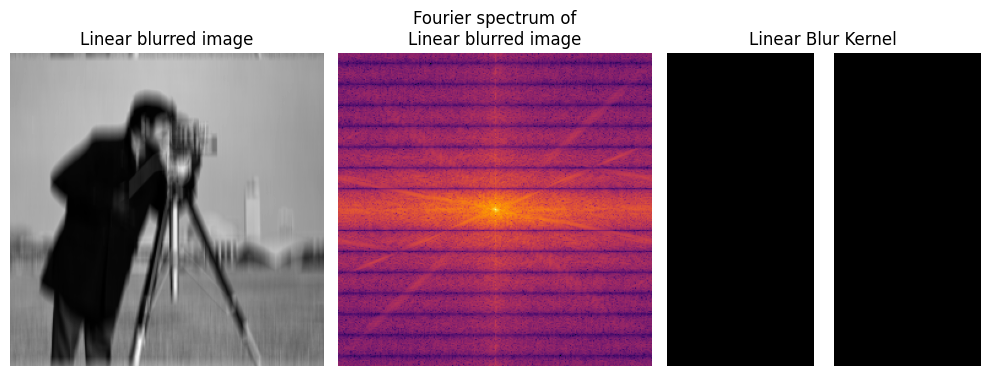

In [7]:
# Parameters
kernel_size = 15
angle = 90   # (in degrees)

# Kernel creation
linear_kernel = linear_motion_blur_kernel(kernel_size, angle)

# Applying linear motion blur
blurred_image = convolve2d(vanilla_image,
                           linear_kernel,
                           mode='same',
                           boundary='wrap')

# Fourier transform of the blurred image
ft_lin_blurred_img = ft(blurred_image)

plot_blurred_image(blurred_image,
              ft_lin_blurred_img,
              linear_kernel,
              kernel="Linear")

/Users/matteomorellini/Desktop/Uni/MISP/MISP_project/utils/fourier.py:28: RuntimeWarning: divide by zero encountered in log
  log_fourier_spectrum_shifted = np.log(fourier_spectrum_shifted)


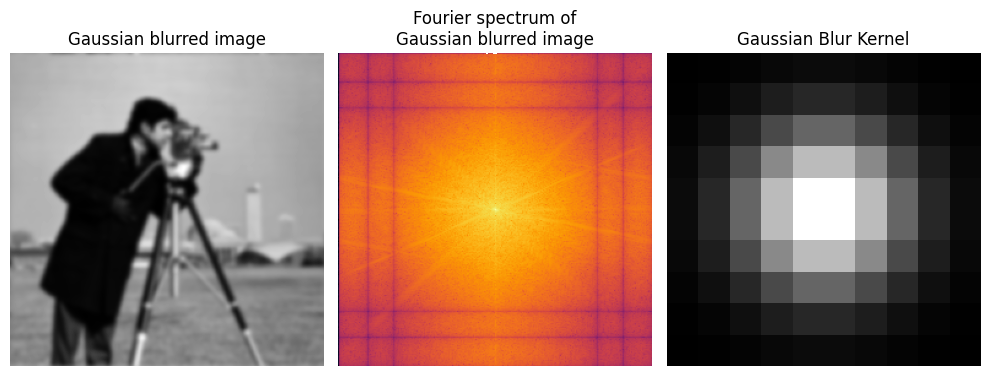

In [8]:
kernel_size, sigma = 10, 2

# Kernel creation
gaussian_blur_kernel = gaussian_kernel(kernel_size, sigma)

# Apply Gaussian blurring
gaussian_blurred_image = convolve2d(vanilla_image,
                                    gaussian_blur_kernel,
                                    mode='same',
                                    boundary='wrap')

# Fourier transform of the blurred image
ft_gaussian_blurred_img = ft(gaussian_blurred_image)

plot_blurred_image(gaussian_blurred_image,
              ft_gaussian_blurred_img,
              gaussian_blur_kernel,
              kernel="Gaussian")

### Inject Noise

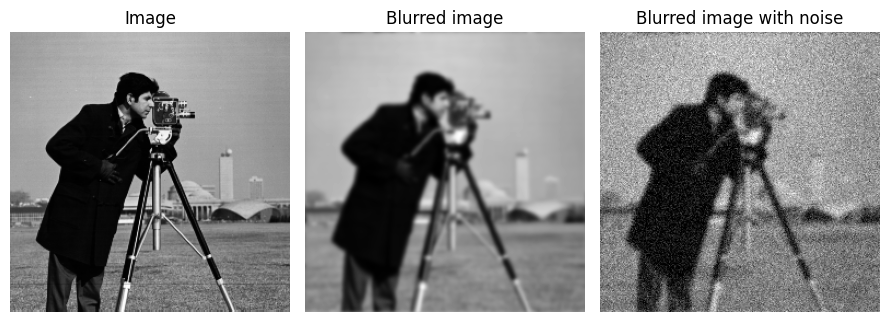

PSNR: 18.86 dB


In [9]:
# Add Gaussian noise to the image
noise_variance = 0.008
noise = np.random.normal(0, np.sqrt(noise_variance), vanilla_image.shape)
noisy_blurred_image = np.clip(gaussian_blurred_image + noise, 0, 1)

# Displaying the images
plot_image_blurred_noise(vanilla_image,
                    gaussian_blurred_image,
                    noisy_blurred_image,)
 

# PSNR value
print(f'PSNR: {psnr(noisy_blurred_image, vanilla_image):.2f} dB')

### Deconvolution of Gaussian Blurred Image + noise

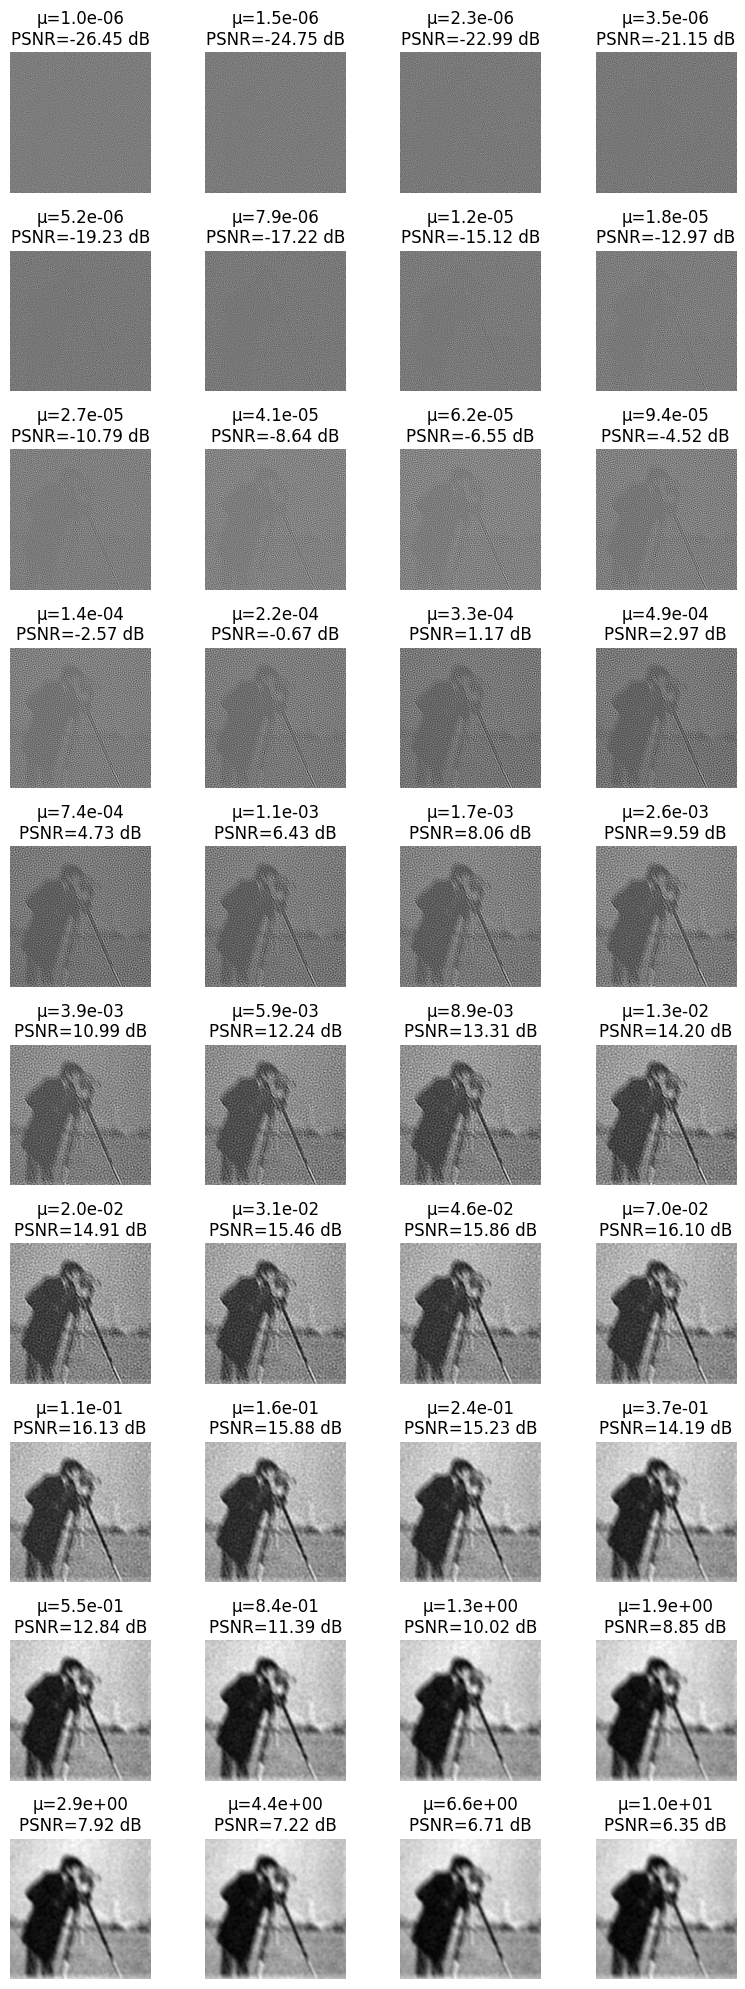

In [30]:
# Compute deconvolution
deconvolved_images_l2, psnr_values_l2, mu_values_l2 = get_inverse("L2",
                                                                vanilla_image,
                                                                noisy_blurred_image,
                                                                gaussian_blur_kernel,
                                                                iter = 40)

# Plotting the deconvoluted images
plot_inverse_images(deconvolved_images_l2,
                                         psnr_values_l2,
                                         mu_values_l2)

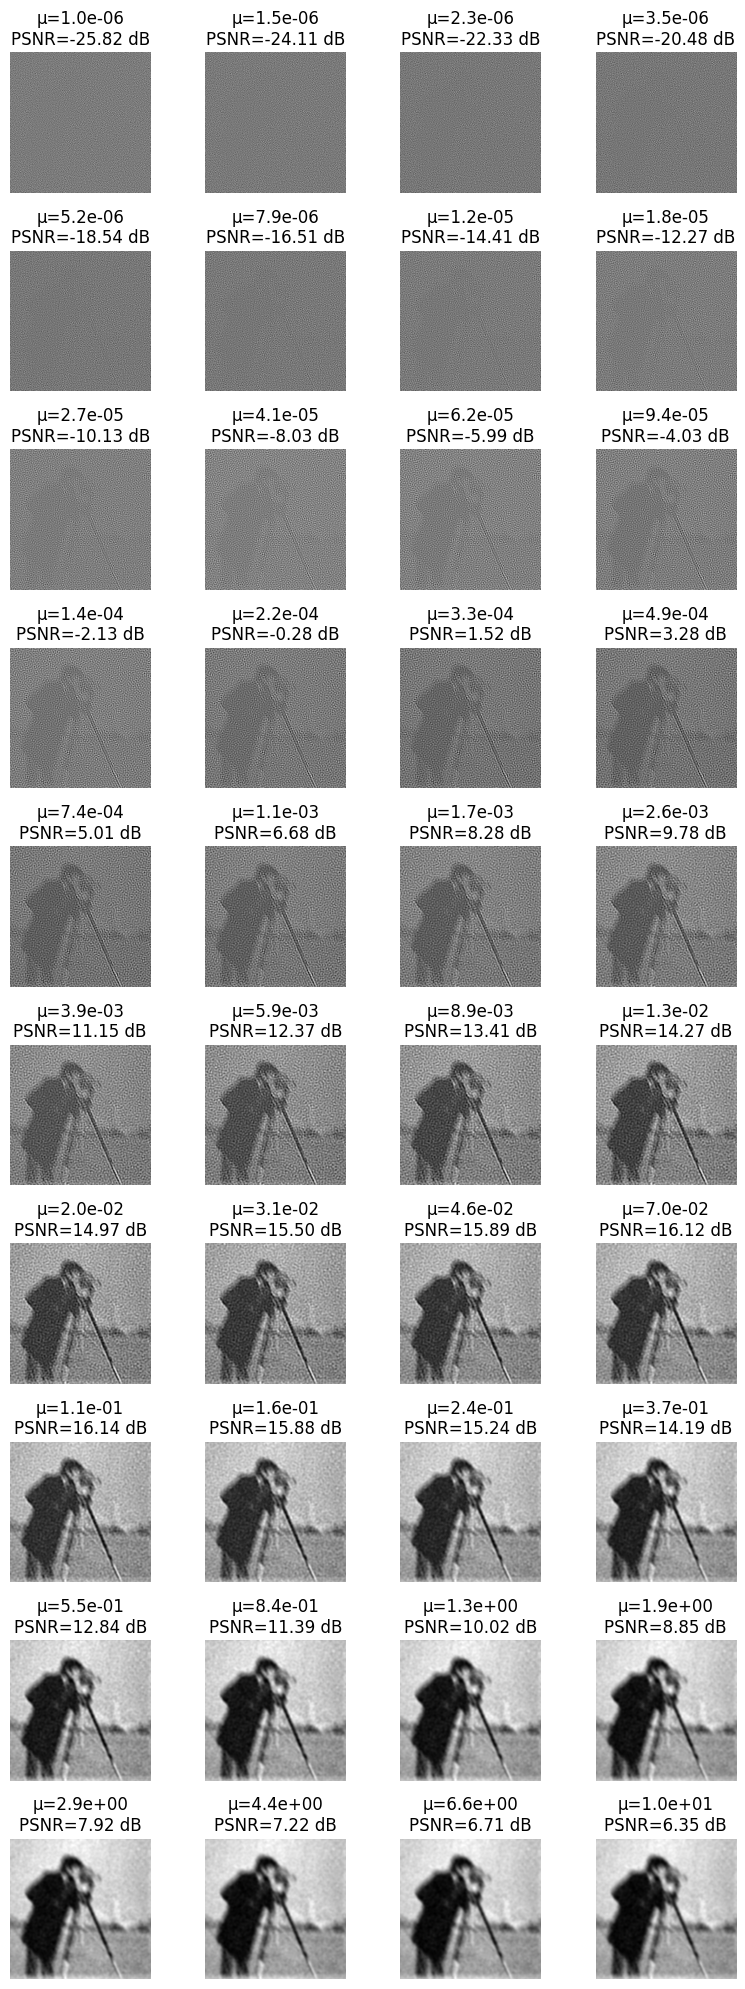

In [31]:
# Compute deconvolution
deconvolved_images_h1, psnr_values_h1, mu_values_h1 = get_inverse("H1",
                                                                vanilla_image,
                                                                noisy_blurred_image,
                                                                gaussian_blur_kernel, 
                                                                iter = 40)

# Plotting the deconvoluted images
plot_inverse_images(deconvolved_images_h1,
                                         psnr_values_h1,
                                         mu_values_h1)

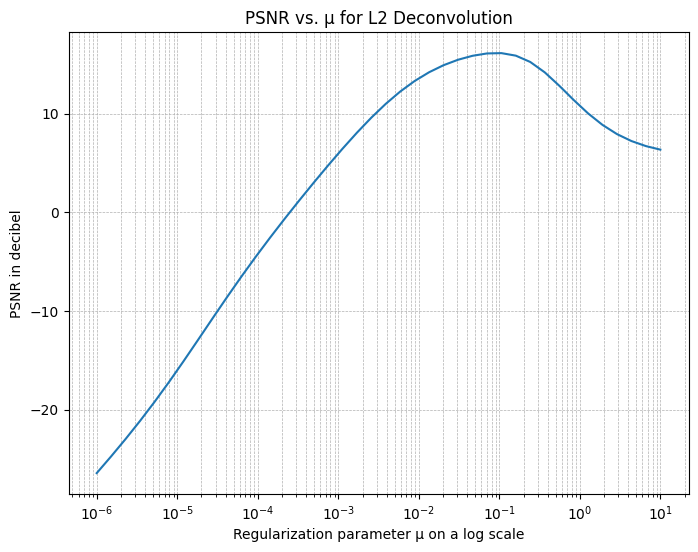

In [32]:
plot_psnr_vs_mu(mu_values_l2, psnr_values_l2, title="PSNR vs. µ for L2 Deconvolution")

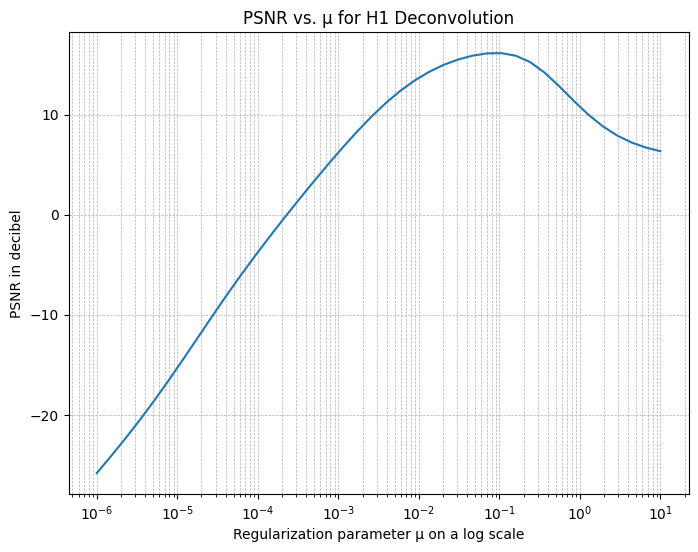

In [33]:
plot_psnr_vs_mu(mu_values_h1, psnr_values_h1, title="PSNR vs. µ for H1 Deconvolution")

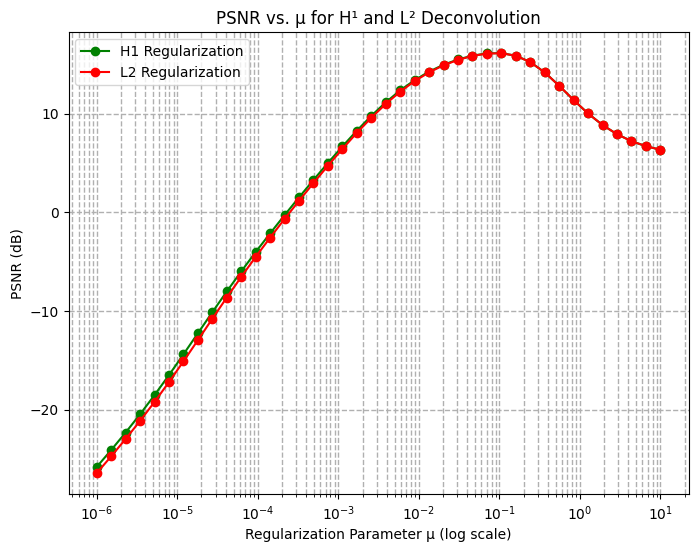

In [34]:
plot_psnr_comparison(mu_values_h1, psnr_values_h1, mu_values_l2, psnr_values_l2)

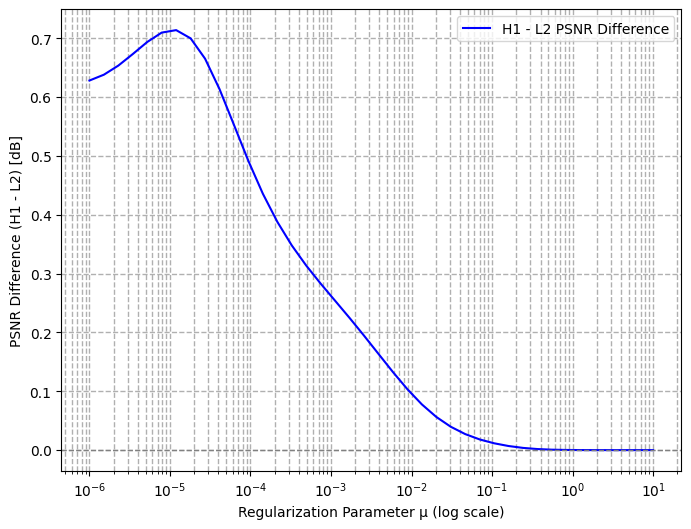

In [36]:
plot_psnr_difference(mu_values_h1, psnr_values_h1, psnr_values_l2)

### Deconvolution with different kernels

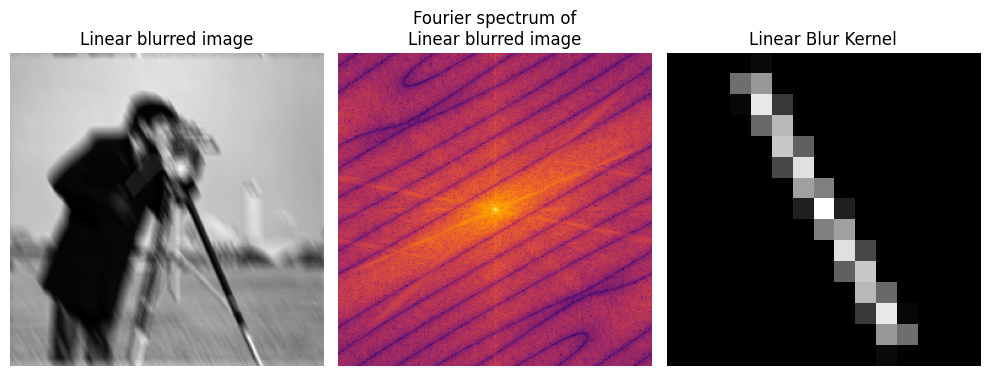

In [ ]:
kernel_size = 15
angle = 120   # (in degrees)

linear_kernel = linear_motion_blur_kernel(kernel_size, angle)

linear_blurred_image = convolve2d(vanilla_image,
                           linear_kernel,
                           mode='same',
                           boundary='wrap')

ft_linear_blurred_img = ft(linear_blurred_image)

plot_blurred_image(linear_blurred_image,
              ft_linear_blurred_img,
              linear_kernel,
              kernel="Linear")

In [18]:
noise_variance = 0.008
noise = np.random.normal(0, np.sqrt(noise_variance), vanilla_image.shape)
noisy_blurred_image = np.clip(linear_blurred_image + noise, 0, 1)

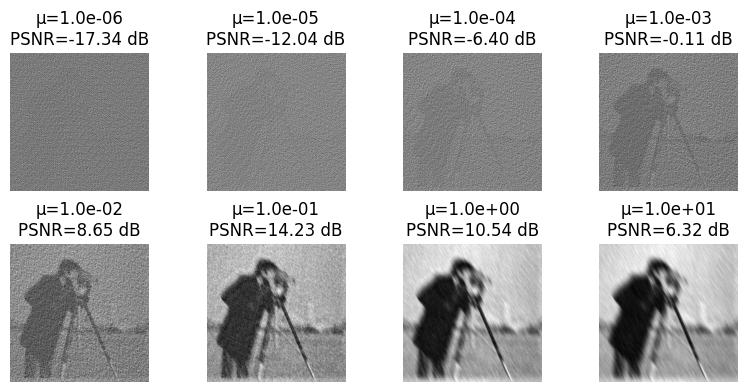

In [ ]:
deconvolved_images_l2, psnr_values_l2, mu_values_l2 = get_inverse("L2",
                                                                vanilla_image,
                                                                noisy_blurred_image,
                                                                linear_kernel)

plot_inverse_images(deconvolved_images_l2,
                    psnr_values_l2,
                    mu_values_l2)

In [ ]:
radius = 5 
kernel_size = 31

diffraction_limited_kernel = diffraction_limited_imaging(radius, kernel_size)

diffraction_limited_image = convolve2d(vanilla_image,
                           diffraction_limited_kernel,
                           mode='same',
                           boundary='wrap')
ft_DL_blurred_img = ft(diffraction_limited_image)

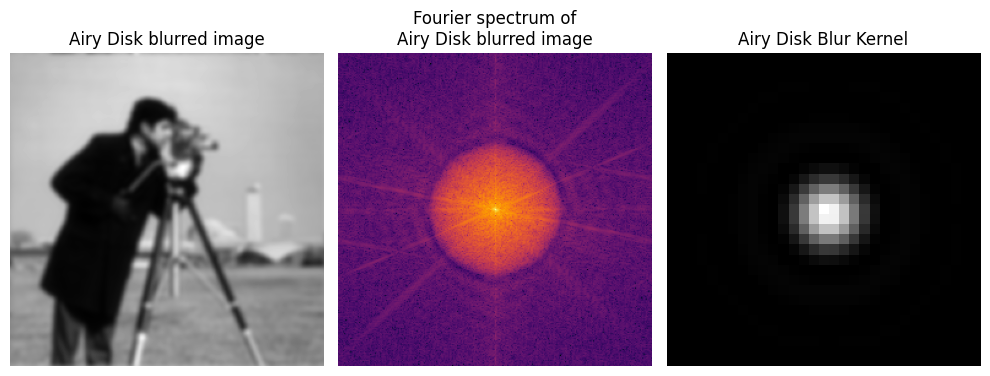

In [ ]:
plot_blurred_image(diffraction_limited_image,
              ft_DL_blurred_img,
              diffraction_limited_kernel,
              kernel="Airy Disk")

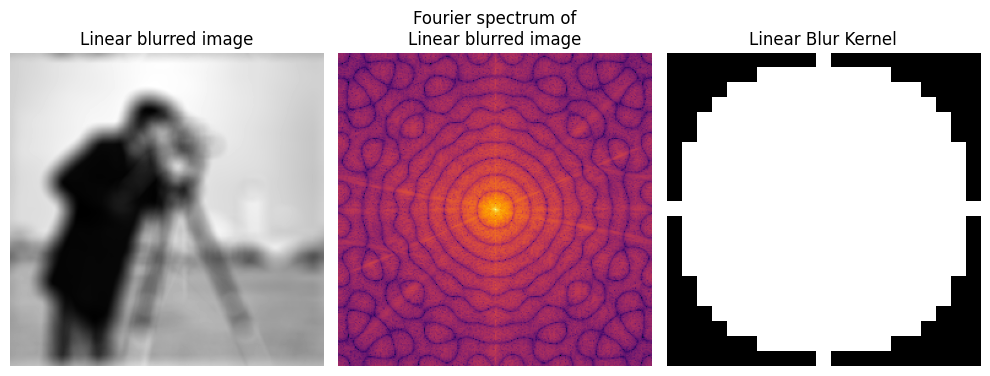

In [ ]:
r = 10
out_of_focus_kernel = out_of_focus_blur_kernel(r)

out_of_focus_image = convolve2d(vanilla_image,
                               out_of_focus_kernel,
                               mode='same',
                               boundary='wrap')

# Fourier transform of the blurred image
ft_out_of_focus_image = ft(out_of_focus_image)

plot_blurred_image(out_of_focus_image,
              ft_out_of_focus_image,
              out_of_focus_kernel,
              kernel="Circle of Confusion")